# 『ゼロから始めるDeepLeaning』7章：畳み込みニューラルネットワーク(CNN)



In [2]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
import sys, os
sys.path.append(os.pardir) # 親ディレクトリのファイルをインポートするための設定

plt.style.use('ggplot')

from mnist import load_mnist
from simple_convnet import SimpleConvNet
from trainer import Trainer
from collections import OrderedDict # Pythonの順序付き辞書型を扱うためのライブラリ
from im2col import *
from layers import *

## im2col(image to column)
畳み込みの実装は，真面目にやるとfor文を繰り返し使用することになります．

これは面倒であると同時に，Numpyとfor文との相性が悪い（計算に時間がかかる）ため処理が遅くなる欠点があります．

そこでim2colという便利な関数を用いたシンプルな実装を行います．

im2colとは，フィルターにとって都合の良いように入力データを展開する関数になります．

具体的には，4次元の入力データ(N,C,H,W)を2次元に変換する手法です．

教科書ではブラックボックスで使用することを想定していますが，中身を以下に示しておきます．また，im2col.pyに同様のコードがありますので必要に応じて参照してください．



In [3]:
def smooth_curve(x):
    """損失関数のグラフを滑らかにするために用いる

    参考：http://glowingpython.blogspot.jp/2012/02/convolution-with-numpy.html
    """
    window_len = 11
    s = np.r_[x[window_len-1:0:-1], x, x[-1:-window_len:-1]]
    w = np.kaiser(window_len, 2)
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[5:len(y)-5]


def shuffle_dataset(x, t):
    """データセットのシャッフルを行う

    Parameters
    ----------
    x : 訓練データ
    t : 教師データ

    Returns
    -------
    x, t : シャッフルを行った訓練データと教師データ
    """
    permutation = np.random.permutation(x.shape[0])
    x = x[permutation,:] if x.ndim == 2 else x[permutation,:,:,:]
    t = t[permutation]

    return x, t
from collections import OrderedDict # Pythonの順序付き辞書型を扱うためのライブラリ
from im2col import *
from layers import *
def conv_output_size(input_size, filter_size, stride=1, pad=0):
    return (input_size + 2*pad - filter_size) / stride + 1


def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """

    Parameters
    ----------
    input_data : (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
    filter_h : フィルターの高さ
    filter_w : フィルターの幅
    stride : ストライド
    pad : パディング

    Returns
    -------
    col : 2次元配列
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col


def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """

    Parameters
    ----------
    col :
    input_shape : 入力データの形状（例：(10, 1, 28, 28)）
    filter_h :
    filter_w
    stride
    pad

    Returns
    -------

    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

実際に実行をしてみましょう．

入力には(バッチサイズ , チャンネル数 , 縦 , 横)という情報を含み，

im2colの引数は(入力データ，フィルターサイズ縦 , フィルターサイズ横 , ストライド幅 , パディングサイズ)という具合になっています．

以下では2つの例を示しています．



In [4]:
x1 = np.random.rand(1, 3, 7, 7) # 入力データ
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape) # (9, 75)

x2 = np.random.rand(10, 3, 7, 7) # 10個のデータ
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape) # (90, 75)

(9, 75)
(90, 75)


## 畳み込み層(Convolution layer)の実装

In [5]:
class Convolution:
    def __init__(self , W , b , stride=1 , pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
    
    def forward(self , x):
        FN , C , FH , FW = self.W.shape
        N , C , H , W = x.shape
        out_h = int(1 + (H + 2*self.pad - FH)/self.stride)
        out_w = int(1 + (W + 2*self.pad - FW)/self.stride)

        col = im2col(x , FH , FW , self.stride , self.pad)
        col_W = self.W.reshape(FN , -1).T
        out = np.dot(col , col_W) + self.b

        out = out.reshape(N , out_h , out_w , -1).transpose(0 , 3 , 1 , 2)
        
        return out

## プーリング層(Pooling layer)の実装

In [6]:
class Pooling:
    def __init__(self , pool_h , pool_w , stride=2 , pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
    
    def forward(self , x):
        N , C , H , W = x.shape
        out_h = int(1 + (H - self.pool_h)/self.stride)
        out_w = int(1 + (W - self.pool_w)/self.stride)

        # 展開
        col = im2col(x , self.pool_h , self.pool_w , self.stride , self.pad)
        col = col.reshape(-1 , self.pool_h*self.pool_w)

        # 最大値
        out = np.max(col , axis=1)

        # 整形
        out = out.reshape(N , out_h , out_w , C).transpose(0 , 3 , 1 , 2)

        return out

## CNNの実装
Convolution層とPooling層を実装したので，いよいよ畳み込みニューラルネットワークの実装に移ります．

### アーキテクチャ(SimpleConvNet)
Convolution - ReLU - Pooling - Affine - ReLU - Affine - Softmax

### 引数
input_dim : 入力データの次元(チャンネル，高さ，幅)

conv_param : 畳み込み層のハイパーパラメータ

hidden_size : 隠れ層

output_size : 出力層

weight_init_std : 初期化時の標準偏差

In [7]:
class SimpleConvNet:
    # SimpleConvNetの初期化処理
    def __init__(self , input_dim=(1 , 28 , 28) , conv_param={'filter_num':30 , 'filter_size':5 , 'pad':0 , 'stride':1} , hidden_size=100 , output_size=10 , weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad)/filter_stride + 1
        pool_output_size = int(filter_num*(conv_output_size/2)*(conv_output_size/2))

        self.params = {}
        self.params['W1'] = weight_init_std*np.random.randn(filter_num , input_dim[0] , filter_size , filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std*np.random.randn(pool_output_size , hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std*np.random.randn(hidden_size , output_size)
        self.params['b3'] = np.zeros(output_size)

        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'] , self.params['b1'] , conv_param['stride'] , conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2 , pool_w=2 , stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'] , self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'] , self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    # 推論処理
    def predict(self , x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    # 損失関数の計算
    def loss(self , x , t):
        y = self.predict(x)
        return self.last_layer.forward(y , t)
    
    # 認識精度の計算
    def gradient(self , x , t):
        # forward
        self.loss(x , t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        
        # 設定
        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affine1'].dW
        grads['b2'] = self.layers['Affine1'].db
        grads['W3'] = self.layers['Affine2'].dW
        grads['b3'] = self.layers['Affine2'].db

        return grads

### MNISTデータセットを用いて学習をしてみましょう

train loss:2.298460636303908
=== epoch:1, train acc:0.187, test acc:0.163 ===
train loss:2.2971245208414897
train loss:2.2906199349988894
train loss:2.284922345974857
train loss:2.2691234920068584
train loss:2.2587504270780605
train loss:2.249871716906336
train loss:2.232892353865462
train loss:2.191000807098546
train loss:2.156144605448751
train loss:2.133098995494571
train loss:2.101903539708646
train loss:1.9988474351028693
train loss:1.9995086037987866
train loss:1.9157854539511743
train loss:1.8250798104875259
train loss:1.8004378899673128
train loss:1.7991230573664165
train loss:1.582687820661106
train loss:1.5176783900889739
train loss:1.3942815298713256
train loss:1.378610501617609
train loss:1.312464805053589
train loss:1.24885891605211
train loss:1.2204355699649136
train loss:1.0128412745427902
train loss:0.9902635876331314
train loss:0.9530049575969004
train loss:0.806682285743738
train loss:1.02920210380748
train loss:0.7758363409445376
train loss:0.6986934376581867
train l

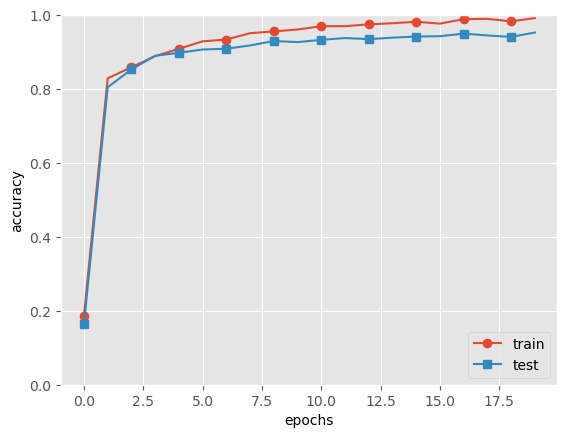

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist
from simple_convnet import SimpleConvNet
from trainer import Trainer

plt.style.use('ggplot')

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 処理に時間のかかる場合はデータを削減 
x_train, t_train = x_train[:5000], t_train[:5000]
x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# パラメータの保存
network.save_params("params.pkl")
print("Saved Network Parameters!")

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

データ数が大きいため減らしましたが，実際にすべてのデータを用いると訓練識別率99.82%，テスト識別率98.96%となるようです．

## CNNの可視化
畳み込み層は”何を見ている"のでしょうか？

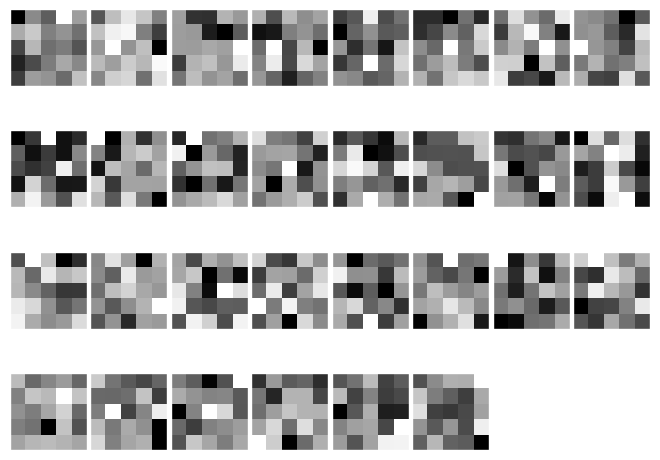

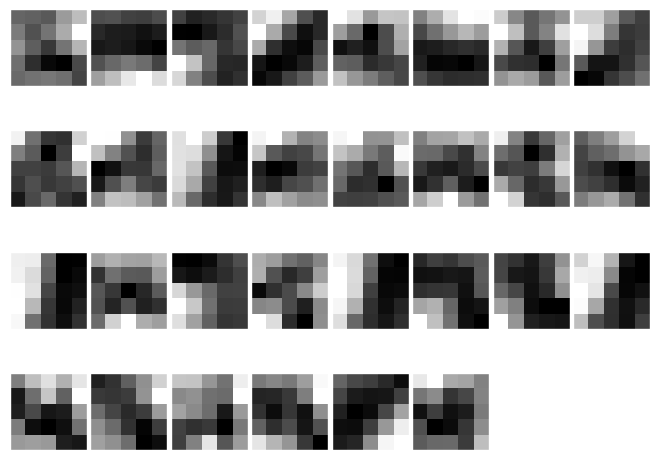

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from simple_convnet import SimpleConvNet

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# ランダム初期化後の重み
filter_show(network.params['W1'])

# 学習後の重み
network.load_params("params.pkl")
filter_show(network.params['W1'])

## 代表的なCNN
### LeNet

### AlexNet